In [ ]:
import jax

jax.config.update("jax_enable_x64", True)


import assist
import astropy.units as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import rebound
from astropy.time import Time
from jplephem.spk import SPK
from rebound import Particle as rebound_Particle

from jorbit import Particle
from jorbit.accelerations import (
    create_default_ephemeris_acceleration_func,
    create_ephem_grav_harmonics_acceleration_func,
    nongrav_acceleration,
)
from jorbit.data.constants import (
    EARTH_J_HARMONICS,
    # EARTH_POLE_DEC,
    # EARTH_POLE_RA,
    EARTH_RADIUS,
    SPEED_OF_LIGHT,
    SUN_J_HARMONICS,
    SUN_POLE_DEC,
    SUN_POLE_RA,
    SUN_RADIUS,
)
from jorbit.ephemeris import Ephemeris, EphemerisProcessor
from jorbit.utils.horizons import horizons_bulk_vector_query
from jorbit.utils.states import CartesianState, SystemState


In [ ]:
ephem = assist.Ephem(
    "/Users/cassese/Downloads/linux_p1550p2650.440",
    "/Users/cassese/Downloads/sb441-n16.bsp",
)

t_initial = Time("2029-01-01").tdb.jd - ephem.jd_ref  # Julian Days relative to jd_ref
t_final = Time("2030-01-01").tdb.jd - ephem.jd_ref
N_samples = 1000
times = np.linspace(t_initial, t_final, N_samples, endpoint=True)


jorb_times = Time(times + ephem.jd_ref, format="jd", scale="tdb")

_horizons_data = horizons_bulk_vector_query(target="99942", center="500@0", times=jorb_times)
horizons_xs_web = jnp.array(_horizons_data[["x", "y", "z"]])
horizons_vs_web = jnp.array(_horizons_data[["vx", "vy", "vz"]])

spk = SPK.open("/Users/cassese/Downloads/sb-99942-220.bsp")
starts = np.array([seg.start_jd for seg in spk.segments])
ends = np.array([seg.end_jd for seg in spk.segments])
order = starts.argsort()
starts = jnp.array(starts[order])
ends = jnp.array(ends[order])
processors = []
for ind in order:
    init, intlen, coeff = spk.segments[ind]._data
    processors.append(
        EphemerisProcessor(
            jnp.array([init]), jnp.array([intlen]), jnp.array([coeff]), jnp.array([0.0])
        )
    )

processor_inds = jnp.searchsorted(starts, jorb_times.tdb.jd) - 1

helio_xs = np.zeros((len(processor_inds), 3))
helio_vs = np.zeros((len(processor_inds), 3))
for i, (ind, t) in enumerate(zip(processor_inds, jorb_times.tdb.jd)):
    _x, _v = processors[ind].state(t)
    helio_xs[i] = _x[0]
    helio_vs[i] = _v[0]

eph = Ephemeris(ssos="default solar system")
horizons_xs = helio_xs + eph.state(jorb_times)["sun"]["x"].value
horizons_vs = helio_vs + eph.state(jorb_times)["sun"]["v"].value

In [22]:
# do the assist integration, copied from the docs

# apophis_initial = apophis_initial_helio + sun_initial
apophis_initial = rebound_Particle(
    x=horizons_xs[0, 0],
    y=horizons_xs[0, 1],
    z=horizons_xs[0, 2],
    vx=horizons_vs[0, 0],
    vy=horizons_vs[0, 1],
    vz=horizons_vs[0, 2],
)


sim = rebound.Simulation()
sim.add(apophis_initial)
sim.t = t_initial
sim.ri_ias15.min_dt = 0.001
extras = assist.Extras(sim, ephem)

# forces = extras.forces
# forces.remove("EARTH_HARMONICS")
# forces.remove("SUN_HARMONICS")
# forces.remove("NON_GRAVITATIONAL")
# forces.remove("ASTEROIDS")
# extras.forces = forces


extras.gr_eih_sources = 11  # Turn on GR for star and all planets

extras.particle_params = np.array([4.999999873689e-13, -2.901085508711e-14, 0.0])


apophis_pos = np.zeros((N_samples, 3))
apophis_vel = np.zeros((N_samples, 3))
earth_pos = np.zeros((N_samples, 3))
dts = np.zeros(N_samples)
dts_last = np.zeros(N_samples)
for i, t in enumerate(times):
    extras.integrate_or_interpolate(t)
    apophis_pos[i] = sim.particles[0].xyz
    apophis_vel[i] = sim.particles[0].vxyz
    earth_pos[i] = ephem.get_particle("earth", t).xyz
    dts[i] = sim.dt
    dts_last[i] = sim.dt_last_done


apophis_final_jpl = rebound_Particle(
    x=horizons_xs[-1, 0],
    y=horizons_xs[-1, 1],
    z=horizons_xs[-1, 2],
    vx=horizons_vs[-1, 0],
    vy=horizons_vs[-1, 1],
    vz=horizons_vs[-1, 2],
)

delta = sim.particles[0] - apophis_final_jpl
delta_pos = np.sqrt(delta.x**2 + delta.y**2 + delta.z**2)
delta_pos *= 149597870700  # convert from AU to meters
print(Time(t_initial + ephem.jd_ref, format="jd").iso)
print(Time(t_final + ephem.jd_ref, format="jd").iso)
print(t_final-t_initial)
print(f"Difference: {delta_pos:.2f} m")

2029-01-01 00:01:09.184
2030-01-01 00:01:09.184
365.0
Difference: 1489.07 m


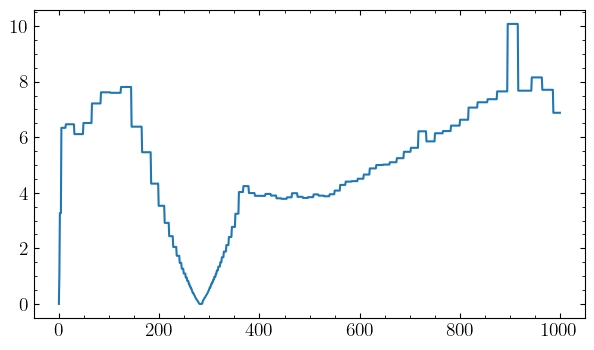

In [34]:
plt.plot(dts)

In [39]:
# create all of the components of the acceleration function
# first, just the usual gravitational acceleration function, GR for planets, newtonian for asteroids

eph = Ephemeris(ssos="default solar system")
acc_func_grav = create_default_ephemeris_acceleration_func(
    ephem_processor=eph.processor
)
# eph = Ephemeris(ssos="default planets")
# acc_func_grav = create_gr_ephemeris_acceleration_func(
#     ephem_processor=eph.processor
# )
# eph = Ephemeris(ssos="default solar system")
# acc_func_grav = create_gr_ephemeris_acceleration_func(
#     ephem_processor=eph.processor
# )


# add the J harmonics for the Sun and Earth
acc_func_solar_harmonics = create_ephem_grav_harmonics_acceleration_func(
    eph.processor, ephem_index=0, state_index=0
)
acc_func_earth_harmonics = create_ephem_grav_harmonics_acceleration_func(
    eph.processor, ephem_index=3, state_index=1
)

# combine those 3, along with the non-gravitational forces
# (which didn't need to be created separately since it just relies on SystemState)
def _acc_func(state: SystemState) -> jnp.ndarray:
    return (
        acc_func_grav(state)
        + nongrav_acceleration(state)
        + acc_func_solar_harmonics(state)
        + acc_func_earth_harmonics(state)
    )
acc_func = jax.tree_util.Partial(_acc_func)


js = jnp.zeros((2, 3))
js = js.at[0,0].set(SUN_J_HARMONICS[0])
js = js.at[1].set(EARTH_J_HARMONICS)


c = CartesianState(
    x=jnp.array([horizons_xs[0]]),
    v=jnp.array([horizons_vs[0]]),
    time=jorb_times[0].tdb.jd,
    acceleration_func_kwargs={
        "c2": SPEED_OF_LIGHT**2,
        "a1": jnp.array([4.999999873689e-13]),
        "a2": jnp.array([-2.901085508711e-14]),
        "a3": jnp.array([0.0]),
        "js_req": jnp.array([SUN_RADIUS, EARTH_RADIUS]),
        # "js_pole_ra": jnp.array([SUN_POLE_RA, EARTH_POLE_RA]),
        # "js_pole_dec": jnp.array([SUN_POLE_DEC, EARTH_POLE_DEC]),
        "js_pole_ra": jnp.array([SUN_POLE_RA, 359.99868*jnp.pi/180]),
        "js_pole_dec": jnp.array([SUN_POLE_DEC, 89.83523*jnp.pi/180]),
        "js": js,
    },
)

p = Particle(state=c, gravity=acc_func)
jorb_xs, jorb_vs = p.integrate(jorb_times)

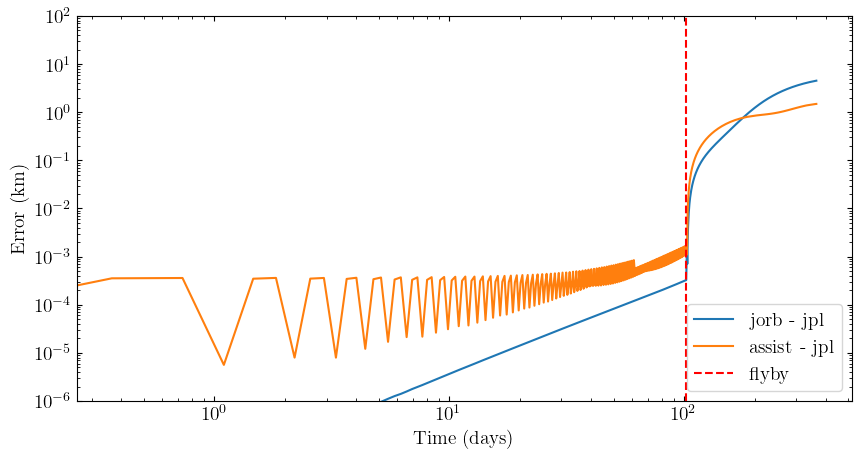

In [ ]:
jorb_err = jnp.linalg.norm(jorb_xs - horizons_xs, axis=1)
assist_err = jnp.linalg.norm(apophis_pos - horizons_xs, axis=1)

flyby_ind = np.argmin(np.abs(jorb_times - Time("2029-04-13")))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(times-times[0], jorb_err*u.au.to(u.km), label="jorb - jpl")
ax.plot(times-times[0], assist_err*u.au.to(u.km), label="assist - jpl")
ax.set(yscale="log", xlabel="Time (days)", ylabel="Error (km)", ylim=(1e-6, 1e2))
ax.axvline(times[flyby_ind] - times[0], color="red", linestyle="--", label="flyby")
ax.legend(loc="lower right")


In [26]:
jnp.max(jorb_err)*u.au.to(u.km)

Array(4.52495192, dtype=float64)

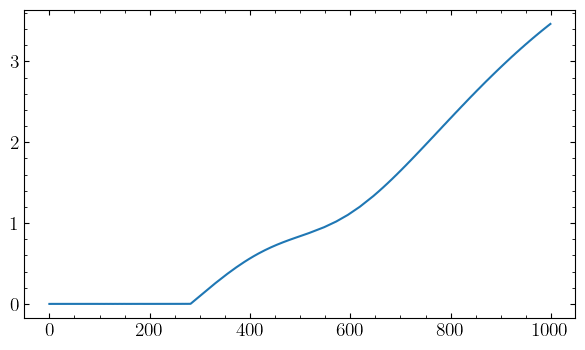

In [27]:
plt.plot(jnp.linalg.norm(jorb_xs - apophis_pos, axis=1)*u.au.to(u.km))

In [29]:
# the harmonics are super important as you get close to earth, way more so than the non-gravs
# the solar harmonics never really matter though

print(nongrav_acceleration(c.to_system()))
print(acc_func_solar_harmonics(c.to_system()))
print(acc_func_earth_harmonics(c.to_system()))
print()

ind = 281
mid_state = CartesianState(
    x=jnp.array([horizons_xs[ind]]),
    v=jnp.array([horizons_vs[ind]]),
    time=jorb_times[ind].tdb.jd,
    acceleration_func_kwargs={
        "c2": SPEED_OF_LIGHT**2,
        "a1": jnp.array([4.999999873689e-13]),
        "a2": jnp.array([-2.901085508711e-14]),
        "a3": jnp.array([0.0]),
        "js_req": jnp.array([SUN_RADIUS, EARTH_RADIUS]),
        # "js_pole_ra": jnp.array([SUN_POLE_RA, EARTH_POLE_RA]),
        # "js_pole_dec": jnp.array([SUN_POLE_DEC, EARTH_POLE_DEC]),
        "js_pole_ra": jnp.array([SUN_POLE_RA, 359.99868*jnp.pi/180]),
        "js_pole_dec": jnp.array([SUN_POLE_DEC, 89.83523*jnp.pi/180]),
        "js": js,
    },
)
print(nongrav_acceleration(mid_state.to_system()))
print(acc_func_solar_harmonics(mid_state.to_system()))
print(acc_func_earth_harmonics(mid_state.to_system()))

[[-2.03925266e-13  3.69954072e-13  1.32295184e-13]]
[[ 8.05537805e-16 -1.38477552e-15  1.02176656e-17]]
[[1.00339921e-19 6.73151709e-21 7.65058215e-20]]

[[-4.66707103e-13 -1.58134283e-13 -7.06173484e-14]]
[[1.85895950e-15 5.49176357e-16 6.87024715e-16]]
[[1.16676288e-09 3.14249705e-10 3.07345856e-09]]


In [30]:
# checking that we're putting the planets in the same place as ASSIST
assist_earth_pos = ephem.get_particle("earth", jorb_times[ind].tdb.jd - ephem.jd_ref).xyz
jorb_earth_pos = eph.state(jorb_times[ind])["earth"]["x"].value

print(jnp.array(assist_earth_pos) - jorb_earth_pos)

assist_moon_pos = ephem.get_particle("moon", jorb_times[ind].tdb.jd - ephem.jd_ref).xyz
jorb_moon_pos = eph.state(jorb_times[ind])["moon"]["x"].value

print(jnp.array(assist_moon_pos) - jorb_moon_pos)

[ 3.99680289e-15 -9.99200722e-15 -4.38538095e-15]
[ 3.88578059e-15 -9.71445147e-15 -4.21884749e-15]
